In [13]:
from __future__ import annotations

import time

import mlflow
import onnx
import torch as th
from pettingzoo.test import api_test
from sb3_contrib import MaskablePPO
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from sb3_contrib.common.wrappers import ActionMasker

from lib.action_mask_wrapper import SB3ActionMaskWrapper
from lib.briscola.game import BriscolaGame
from lib.briscola_env.briscola_env import BriscolaEnv
from lib.briscola_env.embedding import game_embedding
from lib.onnxable import OnnxableMaskableACPolicy

In [2]:
PLAYER_COUNT = 4
NUM_TRAINING_STEPS = 1_000
NUM_EVAL_GAMES = 10

MODEL_HYPERPARAMS = {
	"n_steps": 2048,
	"batch_size": 64,
	"learning_rate": 3e-4,
	"ent_coef": 0.001,
	"vf_coef": 0.65,
	"normalize_advantage": True,
}

def make_env():
	return BriscolaEnv(num_players=PLAYER_COUNT)

def make_model(env):
	return MaskablePPO(
        MaskableActorCriticPolicy, 
        env, 
        verbose=1,
        **MODEL_HYPERPARAMS,
    )

api_test(make_env(), num_cycles=1000)


Starting API test
Passed API test


/home/tim/src/briscola-py/.venv/lib/python3.11/site-packages/pettingzoo/test/api_test.py:242: UserWarning: Observation space for each agent probably should be gymnasium.spaces.box or gymnasium.spaces.discrete
  warnings.warn(
/home/tim/src/briscola-py/.venv/lib/python3.11/site-packages/pettingzoo/test/api_test.py:140: UserWarning: Observation is not a NumPy array
  warnings.warn("Observation is not a NumPy array")
/home/tim/src/briscola-py/.venv/lib/python3.11/site-packages/pettingzoo/test/api_test.py:660: UserWarning: Environment has not defined a render() method
  warnings.warn("Environment has not defined a render() method")


In [3]:
def train(
    steps: int = 10_000, seed: int | None = 0, **env_kwargs
):
    # Train a single model to play as each agent in a cooperative Parallel environment
    env = SB3ActionMaskWrapper(make_env())
    env.reset(seed=seed)

    def mask_fn(env):
        return env.action_mask()
    env = ActionMasker(env, mask_fn)

    print(f"Starting training on {str(env.metadata)}.")
    model = make_model(env)
    model.set_random_seed(seed)
    model.learn(total_timesteps=steps)
    model_path = f"{env.unwrapped.metadata.get('name')}_{time.strftime('%Y%m%d-%H%M%S')}"
    model.save(model_path)

    print("Model has been saved.")
    print(f"Finished training on {str(env.unwrapped.metadata['name'])}.\n")
    env.close()
    return model, model_path


In [4]:
training_result, model_path = train(steps=NUM_TRAINING_STEPS)

Starting training on {'render_modes': []}.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 40       |
|    ep_rew_mean     | 217      |
| time/              |          |
|    fps             | 280      |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 2048     |
---------------------------------
Model has been saved.
Finished training on briscola.



In [5]:
# Evaluation Code
def make_results(agents, wins, total_rewards):
    player_results = []
    total_wins = sum(wins.values())
    print("Winrates:")
    for p in agents:
        winrate = wins[p] / total_wins
        print(f"\t{p}: {winrate*100}%")
        print(f"\tWins: {wins[p]} Rewards: {total_rewards[p]}")
        player_results.append({"winrate": winrate, "total_rewards": total_rewards[p]})
    return player_results

def eval_action_mask(player, num_games=100):
    # Evaluate a trained agent vs a random agent
    env = make_env()
    print("Starting evaluation vs random agents.")
    if player != -1:
        print(f"Trained agent will play as {env.possible_agents[player]}")

    print("Using policy:", model_path)
    model = MaskablePPO.load(model_path)

    wins = {agent: 0 for agent in env.possible_agents}
    total_rewards = {agent: 0 for agent in env.possible_agents}
    for i in range(num_games):
        env.reset(seed=i)
        for agent in env.agent_iter():
            obs, reward, termination, truncation, info = env.last()
            observation, action_mask = obs.values()
            if termination or truncation:
                winner = max(env.rewards, key=env.rewards.get)
                wins[winner] += env.infos[winner]["wins"] 
                for a in env.possible_agents:
                    total_rewards[a] += env.rewards[a]
                break
            else:
                # Act randomly unless it's the agents turn
                if player == -1 or agent != env.possible_agents[player]:
                    act = env.action_space(agent).sample(action_mask)
                else:
                    act = int(
                        model.predict(
                            observation, action_masks=action_mask, deterministic=True
                        )[0]
                    )
            env.step(act)
    env.close()
    return make_results(env.agents, wins, total_rewards)


In [6]:
# Run Evaluations
baseline_results = eval_action_mask(-1, num_games=NUM_EVAL_GAMES)
results_by_position = []
for position in range(PLAYER_COUNT):
	results_by_position.append(eval_action_mask(position, num_games=NUM_EVAL_GAMES))

Starting evaluation vs random agents.
Using policy: briscola_20250504-180157
Winrates:
	player_0: 20.0%
	Wins: 2 Rewards: 205
	player_1: 50.0%
	Wins: 5 Rewards: 940
	player_2: 10.0%
	Wins: 1 Rewards: 115
	player_3: 20.0%
	Wins: 2 Rewards: 399
Starting evaluation vs random agents.
Trained agent will play as player_0
Using policy: briscola_20250504-180157
Winrates:
	player_0: 20.0%
	Wins: 2 Rewards: 302
	player_1: 40.0%
	Wins: 4 Rewards: 667
	player_2: 10.0%
	Wins: 1 Rewards: 121
	player_3: 30.0%
	Wins: 3 Rewards: 517
Starting evaluation vs random agents.
Trained agent will play as player_1
Using policy: briscola_20250504-180157
Winrates:
	player_0: 0.0%
	Wins: 0 Rewards: 3
	player_1: 40.0%
	Wins: 4 Rewards: 698
	player_2: 10.0%
	Wins: 1 Rewards: 54
	player_3: 50.0%
	Wins: 5 Rewards: 827
Starting evaluation vs random agents.
Trained agent will play as player_2
Using policy: briscola_20250504-180157
Winrates:
	player_0: 10.0%
	Wins: 1 Rewards: 60
	player_1: 30.0%
	Wins: 3 Rewards: 619
	pl

In [7]:
# Plotting Code
import matplotlib.pyplot as plt
import numpy as np

def make_plot(winrate_data, title):
	winrates = np.transpose(np.array([
		[entry['winrate'] for entry in sublist] 
		for sublist in winrate_data
   	]))
	fig, ax = plt.subplots(figsize=(8, 6))

	# How many groups and bars
	num_positions, num_players = winrates.shape
	x = np.arange(num_players)

	# Width of each bar group
	bar_width = 0.2
	
	# Plot each group's bars
	for i in range(num_positions):
		ax.bar(x + i * bar_width, winrates[i], width=bar_width, label=f'Player {i}')

	# Labels and stuff
	ax.set_xlabel('Model Position')
	ax.set_ylabel('Winrate')
	ax.set_title(title)
	ax.set_xticks(x + bar_width * (num_positions-1) / 2)
	ax.set_xticklabels([str(i) for i in range(num_players)])
	ax.legend()

	plt.tight_layout()
	plt.show()
	plt.close(fig)


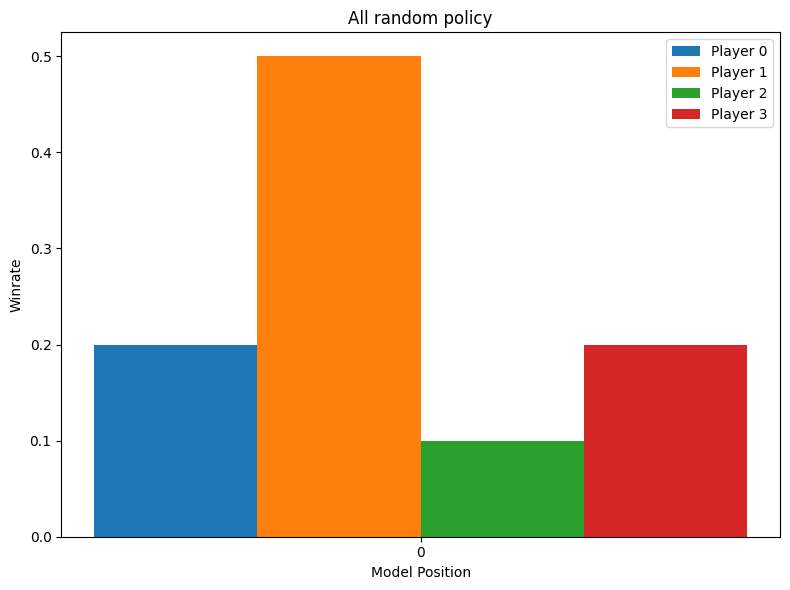

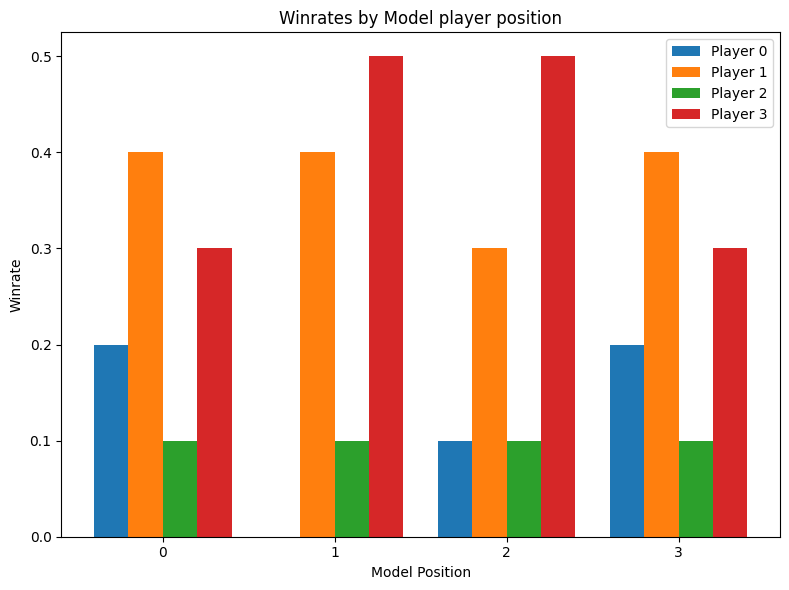

In [8]:
# Generate diagrams
make_plot([baseline_results], "All random policy")
make_plot(results_by_position, "Winrates by Model player position")

In [9]:
# Export to Onnx
def onnx_export():
    model_source_file = model_path
    model_dest_file = f"{model_path}-probdist.onnx"
    model = MaskablePPO.load(model_source_file, device="cpu")
    onnx_policy = OnnxableMaskableACPolicy(model.policy)
    observation_size = model.observation_space.shape
    dummy_input = th.randn(1, *observation_size)
    th.onnx.export(
        onnx_policy,
        dummy_input,
        model_dest_file,
        opset_version=17,
        input_names=["input"],
        output_names=["dist", "values"]
    )
    onnx_model = onnx.load(model_dest_file)
    print(f"Onnx model exported to {model_dest_file}")
    return onnx_model, model_dest_file
onnx_model, onnx_file = onnx_export()

Onnx model exported to briscola_20250504-180157-probdist.onnx


In [ ]:
mlflow.set_tracking_uri("http://localhost:8081")
mlflow.set_experiment("Briscola AI")

with mlflow.start_run():
    mlflow.set_tag("Training Info", f"{PLAYER_COUNT} player model")

    mlflow.log_param("num_players", PLAYER_COUNT)
    mlflow.log_param("num_training_steps", NUM_TRAINING_STEPS)
    mlflow.log_param("num_eval_games", NUM_EVAL_GAMES)
    mlflow.log_params(MODEL_HYPERPARAMS)

    for i, result in enumerate(results_by_position):
        mlflow.log_metric(
            f"baseline_winrate_player_{i}", baseline_results[i]["winrate"]
        )
        mlflow.log_metric(
            f"baseline_total_rewards_player_{i}", baseline_results[i]["total_rewards"]
        )
        mlflow.log_metric(f"winrate_player_{i}", result[0]["winrate"])
        mlflow.log_metric(f"total_rewards_player_{i}", result[0]["total_rewards"])

    example_input = game_embedding(BriscolaGame(players=PLAYER_COUNT), 0)
    sig = mlflow.models.infer_signature(example_input)
    mlflow.pytorch.log_model(
        training_result.policy,
        model_path,
        signature=sig,
        registered_model_name="briscola",
    )
    mlflow.onnx.log_model(
        onnx_model,
        onnx_file,
        signature=sig,
        registered_model_name="briscola_onnx",
    )


2025/05/04 18:03:57 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: IndexError('Dimension out of range (expected to be in range of [-1, 0], but got 1)'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.
2025/05/04 18:04:01 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/05/04 18:04:01 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": [
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    17,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,


🏃 View run blushing-bug-20 at: http://localhost:8081/#/experiments/978895304400746354/runs/6107a005f4694a4da897bee629c42a18
🧪 View experiment at: http://localhost:8081/#/experiments/978895304400746354


Created version '2' of model 'briscola_onnx'.
